# Solving exercise 1

In [1]:
import numpy as np
from numba import jit
import math as m


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

## Solving S.E.

**Numerov algorithm** is a recipe to solve second order differential equation in the form of:
$$\frac{d^2 y(x)}{dx^2} + g(x)y(x) - s(x) = 0$$
Therefore is suitable to solve the Schroedinger equation in one dimension 
$$\frac{d^2 \psi(x)}{dx^2} + k^2(x)\psi(x)= 0$$ where $k^2(x)=\frac{2 m}{\hbar^2}(E-V(x))$.

In our units, $k^2 = 2 ( E - V(x) )$.

By writing down the discretised version of the derivative and doing the math, we obtain the *rule* to propagate the solution of our equation:

$$y_{i+1} = \big[ 2 y_i \big(1 - 5 \frac{h^2}{12} k^2_i \big) - y_{i-1} \big( 1 + \frac{h^2}{12} k^2_{i-1}\big) \big] / 
            \big( 1 + \frac{h^2}{12} k^2_{i+1}\big)$$ 
where $h$ is now the spacing of our grid, and $y_i=y(x_i)$ in the discretised version.

As we see, we need 2 values of $y$ to propagate the solution.

The **Schroedinger equation** is not an initial values problem. It's a boundary condition problem!
We want a solution that $\lim_{x\to\infty}\psi(x) = 0$. Moreover each solution has a corresponding eigenvalue for the energy, $E$, that is not known *a priori*.
Therefore we need a further step.

**>>>> WRITE MORE>>>**

In [3]:
def V(x):
    """Potential to be applied in the Schroedinger equation"""
    return .5*x*x

def g(x, E):
    return 2.*(E - V(x))


In [4]:
x_min = -5.
x_max =  5.
h     =  .001
x     = np.arange(x_min, x_max+h, h)
y     = np.zeros(len(x))
E     = .99

In [5]:
@jit
def numerov(x, y, E, h):
    """It assumes that y0 and y1 are correctly set.
    """
    y[0] = 0
    y[1] = h
    k2 = g(x, E)
    h12 = h*h/12.
    for i in range(2,len(x)):
        y[i] = (2*y[i-1]*(1-5*h12*k2[i-1]) - y[i-2]*(1+h12*k2[i-2])) / (1+h12*k2[i])
    return y

In [6]:
def integrate1(f, step):
    """Trapezoidal rule"""
    integral = sum(f[1:-1])
    integral += 0.5*(f[0]+f[-1])
    integral = step * integral
    return integral

hh = 0.000001
f = np.cos(np.arange(0, 10+hh, hh))
f = 1.+0*f

I = integrate1(f, step=hh)
assert I - 10 < hh, "Your trapezoidal rule does not integrate correctly f(x) = 1 with x from [0, 10]"


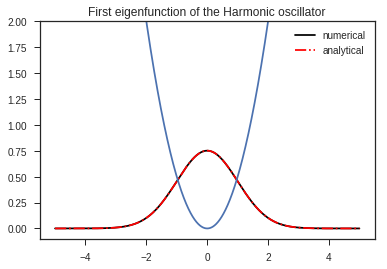

In [7]:
@jit
def hermite_1(x):
    return m.pow(1./m.pi, 0.25) * np.exp(-0.5*x*x)

with plt.style.context("seaborn-ticks"):
    h = 0.001
    z = numerov(x, y, E=.5, h=h)
    norm = 1./m.sqrt(integrate1(z*z, step=h))
    z = z*norm
    plt.plot(x, z,"k-", label="numerical")
    plt.plot(x, hermite_1(x),"r-.", label="analytical")
    plt.plot(x, V(x))
    plt.ylim((-0.1, 2))
    plt.title("First eigenfunction of the Harmonic oscillator")
    plt.legend()


CPU times: user 987 ms, sys: 35.6 ms, total: 1.02 s
Wall time: 1.02 s


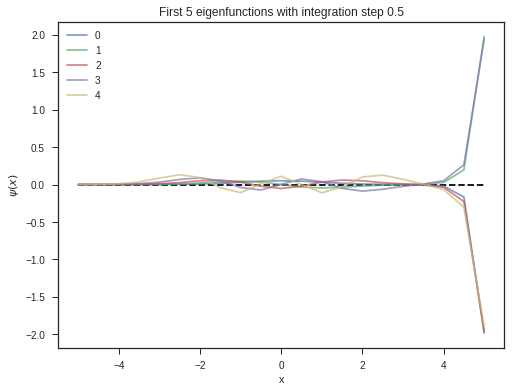

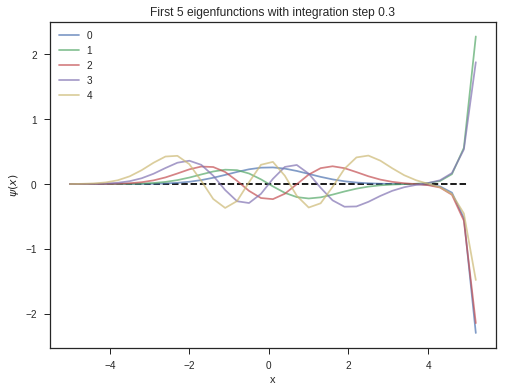

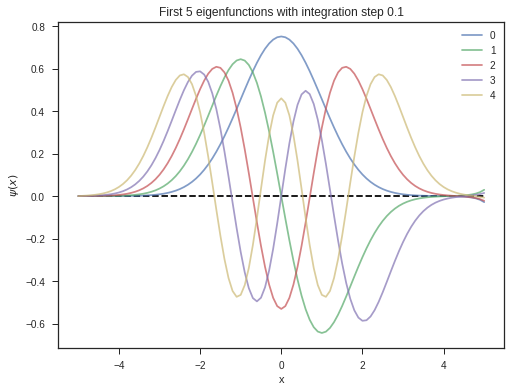

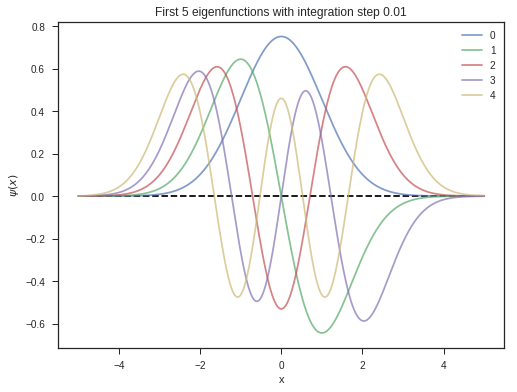

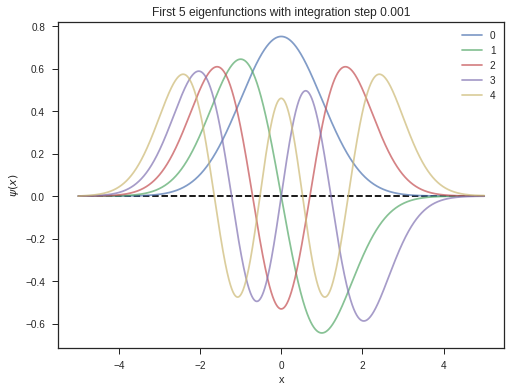

In [8]:
%%time
for h in [ 0.5, 0.3, 0.1, 0.01, 0.001]:
    x     = np.arange(x_min, x_max+h, h)
    y     = np.zeros(len(x))
    with plt.style.context("seaborn-ticks"):
        fig = plt.figure(figsize=(8,6))
        for e in [.5, 1.5, 2.5, 3.5, 4.5]:
            z = numerov(x, y, E=e, h=h)
            norm = 1./m.sqrt(integrate1(z*z, step=h))
            z = z*norm
            plt.plot(x,z, label=str(int(e-.5)), alpha=.7)
        plt.hlines(y=0, xmin=-5, xmax=5, linestyles="--")
        plt.legend()#, x, V(x))
        plt.title("First 5 eigenfunctions with integration step {}".format(h))
        plt.xlabel("x")
        plt.ylabel("$\psi (x)$")
        plt.savefig("tex/img/eigenfuncts_step{}.pdf".format(str(h).split(".")[1]), format="pdf")

### Looking for the eigenvalues.


In [9]:
def find_E2(E0, E1, F0, F1):
    """Secant method"""
    return E0 - F0/(F1-F0)*(E1-E0)


In [10]:
E  = 0. # wrong eigenvalue
dE = float(0.04) #increment for the energy eigenvalue

F = []
F.append(numerov(x, y, E=E, h=h)[-1])
for m in range(1,15):
    e = E + m*dE
    z = numerov(x, y, E=e, h=h)
    F.append(z[-1])
    if F[-1]/F[-2] < 0:
        print(m-1)
        break

print("In this way I found the interval of energy in which my eigenvalue is [{:.2f}:{:.2f}]".format(e-dE, e))
print("Now I need to refine the value")


12
In this way I found the interval of energy in which my eigenvalue is [0.48:0.52]
Now I need to refine the value


In [11]:
E0 = e-dE
E1 = e 
F0 = F[12]
F1 = F[13]

print(F1)
while ( abs(F1) > .0001):
    E2 = find_E2(E0, E1, F0, F1)

    F2 = numerov(x, y, E=E2, h=h)[-1]
    print("F2/F1 = {}".format(F2/F1))
    if F2/F1 < 0:
        E0 = E1
        F0 = F1
        E1 = E2
        F1 = F2
    else:
        E1 = E2
        F1 = F2

    print("E0 = {}, E1 = {}".format(E0, E1))
    print("Before next iteration F1 = {}".format(F1))
    
print("Final results: {}".format(round(0.5*(E1+E2),5)))

-48959956.92305663
F2/F1 = 0.09572414574470173
E0 = 0.48000000000000004, E1 = 0.5017655055026499
Before next iteration F1 = -4686650.052156991
F2/F1 = 0.0853491946297434
E0 = 0.48000000000000004, E1 = 0.5001496105446028
Before next iteration F1 = -400001.8074630441
F2/F1 = 0.08448838436206722
E0 = 0.48000000000000004, E1 = 0.5000126327647414
Before next iteration F1 = -33795.50645445928
F2/F1 = 0.08441593113677441
E0 = 0.48000000000000004, E1 = 0.5000010664220849
Before next iteration F1 = -2852.87914559205
F2/F1 = 0.0844101575392986
E0 = 0.48000000000000004, E1 = 0.5000000900861611
Before next iteration F1 = -240.81197812000454
F2/F1 = 0.08441414047150878
E0 = 0.48000000000000004, E1 = 0.5000000076738316
Before next iteration F1 = -20.32793614824396
F2/F1 = 0.08453652083216764
E0 = 0.48000000000000004, E1 = 0.5000000007170681
Before next iteration F1 = -1.7184529976709992
F2/F1 = 0.08681815034411865
E0 = 0.48000000000000004, E1 = 0.5000000001289675
Before next iteration F1 = -0.149192

### 3D harmonic oscillator

The 3D harmonic oscillator has the following effective potential potential in spherical coordinates:
$$V_{3D}(r, l) = 0.5~\frac{l (l+1)}{r^2} + V(r)$$
so that:
$$ k^2(r, l) = 2~\big( E - V_{3D}(r, l) \big)$$

It's worth noting that the Schroedinger equation is solved for the function $u_{nl}(r) = \frac{\psi_{nl}(r)}{r}$.

In [45]:
def V_3D(r, l):
    """The potential is not defined in r = 0.
    """
    v = np.zeros(len(r))
    v[1:] = .5 * l*(l+1)/(r[1:]*r[1:]) + .5 * r[1:]*r[1:]
    return v

In [46]:
r = np.arange(0, 10.001, 0.001)

(0, 100)

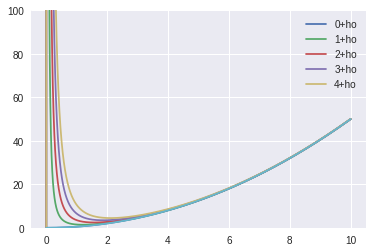

In [47]:
for l in range(5):
    plt.plot(r, V_3D(r, l), label=str(l)+"+ho")

plt.plot(r, V(r))
plt.legend()
plt.ylim((0, 100))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 100, fargs=(data, l),
                                   interval=50, blit=True, repeat=False)
HTML(line_ani.to_html5_video())

In [ ]:
    
E2 = find_E2(E0, E1, F0, F1)
      
F2 = numerov(x, y, E=E2, h=h)[-1]
print(F2/F1)
if F2/F1 < 0:
    E0 = E1
    F0 = F1
    E1 = E2
    F1 = F2
else:
    E1 = E2
    F1 = F2

while 

In [ ]:
%%timeit
V(x)

In [ ]:
%%timeit
VV(x)

In [ ]:
def sum_v0(arr):
    tot = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            tot += arr[i,j]
    return tot

@jit
def sum_v1(arr):
    tot = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            tot += arr[i,j]
    return tot

@jit('float32(float32[:,:])')
def sum_v2(arr):
    tot = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            tot += arr[i]
    return tot

In [ ]:
%time 
s = sum_v0(data)

In [ ]:
%time 
s = sum_v1(data)
print(s)

In [ ]:
%time 
s = sum_v2(data)
print(s)